In [ ]:
!pip install -q transformers sentence-transformers datasets accelerate

In [ ]:
import json
import math
import os
from dataclasses import dataclass

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split

from transformers import (
    GPT2LMHeadModel,
    GPT2TokenizerFast,
    get_linear_schedule_with_warmup,
)
from sentence_transformers import SentenceTransformer, util
from datasets import Dataset as HFDataset
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ============
# PATHS: EDIT THESE
# ============
RAW_LM_JSON = "/content/drive/MyDrive/DiffPriv/Yelp/yelp_academic_dataset_review.json"       # 10k raw examples for GPT-2 LM training
EMBED_JSON  = "/content/drive/MyDrive/DiffPriv/Yelp/yelp_review_analysis.json"        # ~1.3k examples for embedding/adapter training

# If your JSON entries use different keys, change these:
TEXT_KEY_LM    = "text"     # key in RAW_LM_JSON for the raw text
TEXT_KEY_EMBED = "Origianal Text"     # key in EMBED_JSON for the text to embed

# ============
# MODEL + TRAINING CONFIG
# ============
GPT2_MODEL_NAME = "gpt2"    # you can change to "gpt2-medium" if you’re brave with VRAM

MAX_LM_EXAMPLES = 30_000    # hard cap for GPT-2 LM training
LM_MAX_SEQ_LEN  = 256       # truncate text to this many tokens
LM_BATCH_SIZE   = 4         # small batch size, we’ll use grad accumulation
LM_NUM_EPOCHS   = 2
LM_LR           = 5e-5
LM_GRAD_ACCUM   = 8         # effective batch = 4 * 8 = 32

# Embedding encoder (frozen)
EMBED_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
EMBED_MAX_EXAMPLES = 2000   # just a safety limit; your 1.3k fits in here

# Adapter training
ADAPTER_BATCH_SIZE = 8
ADAPTER_NUM_EPOCHS = 5
ADAPTER_LR         = 1e-4
MAX_ADAPTER_SEQ_LEN = 128   # shorter context just for the adapter training

# Noise
MAX_EMB_NORM = 5.0
SIGMA = 0.5  # std dev of Gaussian noise (NOT epsilon)

# Save dirs
SAVE_DIR_LM      = "/content/drive/MyDrive/DiffPriv/Models/gpt2_lm"
SAVE_DIR_ADAPTER = "/content/drive/MyDrive/DiffPriv/Models/gpt2_prefix_adapter"

os.makedirs(SAVE_DIR_LM, exist_ok=True)
os.makedirs(SAVE_DIR_ADAPTER, exist_ok=True)


Device: cuda


In [ ]:
import json
import os

def load_texts_from_json(path, text_key="text", max_items=None):
    """
    Robust loader for:
      - normal JSON array: [ {...}, {...}, ... ]
      - single JSON object: { ... }
      - JSON Lines / NDJSON: one JSON object per line
    Extracts the string field `text_key` from each record.
    """
    records = []

    with open(path, "r", encoding="utf-8") as f:
        raw = f.read().strip()

    # First try: standard JSON (list or dict)
    try:
        data = json.loads(raw)

        if isinstance(data, list):
            records = data
        elif isinstance(data, dict):
            # either it's a single record, or maybe there's a top-level "data" list
            if isinstance(data.get("data"), list):
                records = data["data"]
            else:
                records = [data]

    except json.JSONDecodeError:
        # Fallback: treat file as JSON Lines (one JSON object per line)
        records = []
        with open(path, "r", encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                try:
                    obj = json.loads(line)
                    records.append(obj)
                except json.JSONDecodeError:
                    # skip broken lines quietly
                    continue

    texts = []
    for rec in records:
        if not isinstance(rec, dict):
            continue
        val = rec.get(text_key, None)
        if isinstance(val, str):
            texts.append(val)

    if max_items is not None:
        texts = texts[:max_items]

    print(f"Loaded {len(texts)} texts from {os.path.basename(path)} using key '{text_key}'")
    return texts

# Load the two datasets (this reuses your existing config variables)
lm_texts    = load_texts_from_json(RAW_LM_JSON,    text_key=TEXT_KEY_LM,    max_items=MAX_LM_EXAMPLES)
embed_texts = load_texts_from_json(EMBED_JSON,     text_key=TEXT_KEY_EMBED, max_items=EMBED_MAX_EXAMPLES)

print("LM examples:", len(lm_texts))
print("Embed examples:", len(embed_texts))
print("Example LM text:", lm_texts[0][:300] if lm_texts else "NONE")
print("Example embed text:", embed_texts[0][:300] if embed_texts else "NONE")


Loaded 30000 texts from yelp_academic_dataset_review.json using key 'text'
Loaded 0 texts from yelp_review_analysis.json using key 'Origianal Text'
LM examples: 30000
Embed examples: 0
Example LM text: If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We have tried it multiple times, because I want to like it! I have been to it's other locations in NJ and never had a bad experience. 

The food is good, but it takes a very long time to come out. The w
Example embed text: NONE


In [ ]:
tokenizer = GPT2TokenizerFast.from_pretrained(GPT2_MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

gpt2_lm = GPT2LMHeadModel.from_pretrained(GPT2_MODEL_NAME)
gpt2_lm.resize_token_embeddings(len(tokenizer))
gpt2_lm.to(device)

class LMTextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        txt = self.texts[idx]
        enc = self.tokenizer(
            txt,
            truncation=True,
            max_length=self.max_length,
            padding="max_length",
            return_tensors="pt",
        )
        input_ids = enc["input_ids"].squeeze(0)
        attn_mask = enc["attention_mask"].squeeze(0)
        return {
            "input_ids": input_ids,
            "attention_mask": attn_mask,
        }

lm_dataset = LMTextDataset(lm_texts, tokenizer, LM_MAX_SEQ_LEN)

# Split train/val (90/10)
val_size = max(1, int(0.1 * len(lm_dataset)))
train_size = len(lm_dataset) - val_size
lm_train, lm_val = random_split(lm_dataset, [train_size, val_size])

print(f"LM train size: {len(lm_train)}, val size: {len(lm_val)}")

lm_train_loader = DataLoader(lm_train, batch_size=LM_BATCH_SIZE, shuffle=True)
lm_val_loader   = DataLoader(lm_val, batch_size=LM_BATCH_SIZE, shuffle=False)

from torch.cuda.amp import autocast, GradScaler

optimizer = torch.optim.AdamW(gpt2_lm.parameters(), lr=LM_LR)
num_update_steps_per_epoch = math.ceil(len(lm_train_loader) / LM_GRAD_ACCUM)
num_training_steps = LM_NUM_EPOCHS * num_update_steps_per_epoch

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * num_training_steps),
    num_training_steps=num_training_steps,
)

# This warning is fine – this API is deprecated but still works.
scaler = GradScaler(enabled=(device == "cuda"))

gpt2_lm.train()
global_step = 0

for epoch in range(LM_NUM_EPOCHS):
    running_loss = 0.0
    optimizer.zero_grad()
    pbar = tqdm(lm_train_loader, desc=f"LM Epoch {epoch+1}/{LM_NUM_EPOCHS}")
    for step, batch in enumerate(pbar):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        # 🔧 FIX: no device_type / dtype args here
        with autocast(enabled=(device == "cuda")):
            outputs = gpt2_lm(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=input_ids,
            )
            loss = outputs.loss / LM_GRAD_ACCUM

        scaler.scale(loss).backward()
        # Gradient accumulation
        if (step + 1) % LM_GRAD_ACCUM == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()
            global_step += 1

        running_loss += loss.item() * LM_GRAD_ACCUM
        pbar.set_postfix({"loss": running_loss / (step + 1)})

    # ---- validation ----
    gpt2_lm.eval()
    val_losses = []
    with torch.no_grad():
        for batch in lm_val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            outputs = gpt2_lm(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=input_ids,
            )
            val_losses.append(outputs.loss.item())
    print(f"Val loss after epoch {epoch+1}: {sum(val_losses)/len(val_losses):.4f}")
    gpt2_lm.train()

# Save fine-tuned LM
gpt2_lm.save_pretrained(SAVE_DIR_LM)
tokenizer.save_pretrained(SAVE_DIR_LM)
print("Saved fine-tuned GPT-2 LM to", SAVE_DIR_LM)


LM train size: 27000, val size: 3000


/tmp/ipython-input-1661515078.py:59: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device == "cuda"))


LM Epoch 1/2:   0%|          | 0/6750 [00:00<?, ?it/s]

/tmp/ipython-input-1661515078.py:73: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device == "cuda")):


Val loss after epoch 1: 1.5175


LM Epoch 2/2:   0%|          | 0/6750 [00:00<?, ?it/s]

Val loss after epoch 2: 1.5062
Saved fine-tuned GPT-2 LM to /content/drive/MyDrive/DiffPriv/Models/gpt2_lm


In [ ]:
import json
import torch
from tqdm import tqdm
from sentence_transformers import SentenceTransformer

# ---- Load embedding dataset ----
# Make sure EMBED_JSON_PATH points to your ~1.3k-json file
print("Loading embedding dataset from:", EMBED_JSON)

with open(EMBED_JSON, "r") as f:
    raw = json.load(f)

# Handle a few common JSON shapes: list[...] or {"data": [...]}, {"records": [...]}, etc.
if isinstance(raw, dict):
    if "data" in raw and isinstance(raw["data"], list):
        raw = raw["data"]
    elif "records" in raw and isinstance(raw["records"], list):
        raw = raw["records"]
    else:
        # fallback: collect any list-valued fields
        tmp = []
        for v in raw.values():
            if isinstance(v, list):
                tmp.extend(v)
        if tmp:
            raw = tmp

if not isinstance(raw, list):
    raise ValueError(
        f"Expected embedding JSON to be a list of examples; got {type(raw)}. "
        "Adjust the loader to match your JSON structure."
    )

possible_text_keys = ["Original Text"]
possible_priv_keys = ["Name",	"Location/Address",	"Age",	"Gender",	"Date of Birth",	"Date of Event",	"SSN",	"Email Address",	"Social Media Account",	"Employment Details",	"Miscellaneous"]
possible_util_keys = ["Category",	"Sentiment",	"Rating",	"Keywords",	"Summary"]

embed_texts = []
embed_privacy_labels = []
embed_utility_labels = []

for item in raw:
    if not isinstance(item, dict):
        continue

    # try several possible text field names
    text = None
    for k in possible_text_keys:
        if k in item and isinstance(item[k], str):
            text = item[k].strip()
            break

    if not text:
        continue

    embed_texts.append(text)

    priv = None
    util = None
    for k in possible_priv_keys:
        if k in item:
            priv = item[k]
            break
    for k in possible_util_keys:
        if k in item:
            util = item[k]
            break

    embed_privacy_labels.append(priv)
    embed_utility_labels.append(util)

print(f"Loaded {len(embed_texts)} embedding examples before cap.")

# ---- Cap at ~1.3k for adapter training ----
MAX_ADAPTER_SAMPLES = 1300  # you can tweak this if you want

if len(embed_texts) > MAX_ADAPTER_SAMPLES:
    embed_texts = embed_texts[:MAX_ADAPTER_SAMPLES]
    embed_privacy_labels = embed_privacy_labels[:MAX_ADAPTER_SAMPLES]
    embed_utility_labels = embed_utility_labels[:MAX_ADAPTER_SAMPLES]

print(f"Using {len(embed_texts)} examples for adapter training.")

if len(embed_texts) == 0:
    raise ValueError(
        "No usable texts found in embedding dataset.\n"
        "Check that EMBED_JSON_PATH is correct and that your JSON has a "
        "'text' / 'sentence' / 'content' / 'raw_text' field with strings."
    )

# Keep a clean copy if you need it later
embed_texts_clean = list(embed_texts)

# ---- Precompute sentence embeddings ----
embed_model = SentenceTransformer(EMBED_MODEL_NAME, device=device)
embed_dim = embed_model.get_sentence_embedding_dimension()
hidden_size = gpt2_lm.config.hidden_size
print(f"Embedding dim: {embed_dim} | GPT-2 hidden size: {hidden_size}")

MAX_EMB_NORM = 1.0

embed_embeddings = []
BATCH_SIZE = 32

for i in tqdm(
    range(0, len(embed_texts), BATCH_SIZE),
    desc="Encoding embeddings for adapter dataset"
):
    batch_texts = embed_texts[i:i + BATCH_SIZE]
    embs = embed_model.encode(
        batch_texts,
        convert_to_tensor=True,
        device=device,
        show_progress_bar=False,
        normalize_embeddings=False,
    )
    # Optional: clip norms slightly
    embs = torch.clamp(embs, min=-MAX_EMB_NORM, max=MAX_EMB_NORM)
    embed_embeddings.append(embs.cpu())

# At this point we KNOW the list is non-empty
embed_embeddings = torch.cat(embed_embeddings, dim=0)
print("Final embedding tensor shape:", embed_embeddings.shape)
print("Done precomputing embeddings for adapter dataset.")


Loading embedding dataset from: /content/drive/MyDrive/DiffPriv/Yelp/yelp_review_analysis.json
Loaded 1268 embedding examples before cap.
Using 1268 examples for adapter training.
Embedding dim: 384 | GPT-2 hidden size: 768


Encoding embeddings for adapter dataset: 100%|██████████| 40/40 [00:01<00:00, 22.92it/s]

Final embedding tensor shape: torch.Size([1268, 384])
Done precomputing embeddings for adapter dataset.


In [ ]:
# Load the fine-tuned GPT-2 LM
tokenizer = GPT2TokenizerFast.from_pretrained(SAVE_DIR_LM)
gpt2_base = GPT2LMHeadModel.from_pretrained(SAVE_DIR_LM).to(device)
gpt2_base.eval()  # we'll freeze it for adapter training

for p in gpt2_base.parameters():
    p.requires_grad = False

# Load frozen embedding encoder
embed_model = SentenceTransformer(EMBED_MODEL_NAME, device=device)
embed_dim = embed_model.get_sentence_embedding_dimension()
hidden_size = gpt2_base.config.n_embd
print("Embedding dim:", embed_dim, "| GPT-2 hidden size:", hidden_size)

# Compute embeddings for dataset B
embed_embeddings = []
embed_texts_clean = []

batch_size = 32
for i in tqdm(range(0, len(embed_texts), batch_size), desc="Encoding embeddings for adapter dataset"):
    batch_texts = embed_texts[i : i + batch_size]
    if not batch_texts:
        continue
    embs = embed_model.encode(batch_texts, convert_to_tensor=True, show_progress_bar=False)
    embed_embeddings.append(embs.cpu())
    embed_texts_clean.extend(batch_texts)

embed_embeddings = torch.cat(embed_embeddings, dim=0)
print("Final embedding tensor shape:", embed_embeddings.shape)

class EmbeddingTextDataset(Dataset):
    def __init__(self, embeddings, texts, tokenizer, max_length):
        assert len(embeddings) == len(texts)
        self.embeddings = embeddings
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        emb = self.embeddings[idx]
        txt = self.texts[idx]
        enc = self.tokenizer(
            txt,
            truncation=True,
            max_length=self.max_length,
            padding="max_length",
            return_tensors="pt",
        )
        input_ids = enc["input_ids"].squeeze(0)
        attn_mask = enc["attention_mask"].squeeze(0)
        return {
            "embedding": emb,
            "input_ids": input_ids,
            "attention_mask": attn_mask,
        }

adapter_dataset = EmbeddingTextDataset(
    embed_embeddings,
    embed_texts_clean,
    tokenizer,
    max_length=MAX_ADAPTER_SEQ_LEN,
)

val_size = max(1, int(0.1 * len(adapter_dataset)))
train_size = len(adapter_dataset) - val_size
adapter_train, adapter_val = random_split(adapter_dataset, [train_size, val_size])

print(f"Adapter train size: {len(adapter_train)}, val size: {len(adapter_val)}")

adapter_train_loader = DataLoader(adapter_train, batch_size=ADAPTER_BATCH_SIZE, shuffle=True)
adapter_val_loader   = DataLoader(adapter_val, batch_size=ADAPTER_BATCH_SIZE, shuffle=False)

# Prefix adapter model
class EmbeddingPrefixDecoder(nn.Module):
    def __init__(self, gpt2, embed_dim, hidden_size):
        super().__init__()
        self.gpt2 = gpt2
        self.adapter = nn.Sequential(
            nn.Linear(embed_dim, hidden_size),
            nn.Tanh(),
        )

    def forward(self, embeddings, input_ids, attention_mask):
        """
        embeddings: (B, embed_dim)
        input_ids: (B, L)
        attention_mask: (B, L)
        """
        prefix = self.adapter(embeddings)  # (B, H)
        prefix = prefix.unsqueeze(1)       # (B, 1, H)

        token_embeds = self.gpt2.transformer.wte(input_ids)  # (B, L, H)
        inputs_embeds = torch.cat([prefix, token_embeds], dim=1)  # (B, L+1, H)

        # Extend attention mask with 1 for prefix
        prefix_mask = torch.ones((attention_mask.size(0), 1), device=attention_mask.device, dtype=attention_mask.dtype)
        extended_attention_mask = torch.cat([prefix_mask, attention_mask], dim=1)  # (B, L+1)

        # Labels: ignore prefix position with -100
        labels = input_ids.clone()
        pad_label = -100
        labels_with_prefix = torch.full(
            (labels.size(0), labels.size(1) + 1),
            pad_label,
            device=labels.device,
        )
        labels_with_prefix[:, 1:] = labels

        outputs = self.gpt2(
            inputs_embeds=inputs_embeds,
            attention_mask=extended_attention_mask,
            labels=labels_with_prefix,
        )
        return outputs.loss

embedding_prefix_model = EmbeddingPrefixDecoder(
    gpt2=gpt2_base,
    embed_dim=embed_dim,
    hidden_size=hidden_size,
).to(device)

# Only train adapter params
for p in embedding_prefix_model.gpt2.parameters():
    p.requires_grad = False
for p in embedding_prefix_model.adapter.parameters():
    p.requires_grad = True

trainable_params = sum(p.numel() for p in embedding_prefix_model.parameters() if p.requires_grad)
print("Trainable params (adapter only):", trainable_params)


Embedding dim: 384 | GPT-2 hidden size: 768


Encoding embeddings for adapter dataset: 100%|██████████| 40/40 [00:01<00:00, 22.91it/s]

Final embedding tensor shape: torch.Size([1268, 384])
Adapter train size: 1142, val size: 126
Trainable params (adapter only): 295680


In [ ]:
from torch.cuda.amp import autocast, GradScaler

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, embedding_prefix_model.parameters()),
    lr=ADAPTER_LR,
)

scaler = GradScaler(enabled=(device == "cuda"))

embedding_prefix_model.train()

for epoch in range(ADAPTER_NUM_EPOCHS):
    running_loss = 0.0
    pbar = tqdm(adapter_train_loader, desc=f"Adapter Epoch {epoch+1}/{ADAPTER_NUM_EPOCHS}")
    for batch in pbar:
        embeddings = batch["embedding"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        optimizer.zero_grad()

        # 🔧 FIX: again, no device_type / dtype args
        with autocast(enabled=(device == "cuda")):
            loss = embedding_prefix_model(
                embeddings=embeddings,
                input_ids=input_ids,
                attention_mask=attention_mask,
            )

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        pbar.set_postfix({"loss": running_loss / (len(pbar))})

    # ---- validation ----
    embedding_prefix_model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in adapter_val_loader:
            embeddings = batch["embedding"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            loss = embedding_prefix_model(
                embeddings=embeddings,
                input_ids=input_ids,
                attention_mask=attention_mask,
            )
            val_losses.append(loss.item())
    print(f"Adapter val loss after epoch {epoch+1}: {sum(val_losses)/len(val_losses):.4f}")
    embedding_prefix_model.train()

# Save adapter
adapter_path = os.path.join(SAVE_DIR_ADAPTER, "adapter.pt")
torch.save(
    {
        "adapter_state_dict": embedding_prefix_model.adapter.state_dict(),
        "embed_dim": embed_dim,
        "hidden_size": hidden_size,
        "gpt2_path": SAVE_DIR_LM,
        "embed_model_name": EMBED_MODEL_NAME,
        "max_emb_norm": MAX_EMB_NORM,
    },
    adapter_path,
)
print("Saved adapter to", adapter_path)


/tmp/ipython-input-3063439345.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device == "cuda"))
Adapter Epoch 1/5:   0%|          | 0/143 [00:00<?, ?it/s]/tmp/ipython-input-3063439345.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device == "cuda")):
Adapter Epoch 1/5: 100%|██████████| 143/143 [00:08<00:00, 17.24it/s, loss=3.73]


Adapter val loss after epoch 1: 3.5631


Adapter Epoch 2/5: 100%|██████████| 143/143 [00:08<00:00, 16.84it/s, loss=3.7]


Adapter val loss after epoch 2: 3.5556


Adapter Epoch 3/5: 100%|██████████| 143/143 [00:08<00:00, 17.15it/s, loss=3.69]


Adapter val loss after epoch 3: 3.5522


Adapter Epoch 4/5: 100%|██████████| 143/143 [00:08<00:00, 17.38it/s, loss=3.69]


Adapter val loss after epoch 4: 3.5494


Adapter Epoch 5/5: 100%|██████████| 143/143 [00:08<00:00, 17.66it/s, loss=3.69]


Adapter val loss after epoch 5: 3.5465
Saved adapter to /content/drive/MyDrive/DiffPriv/Models/gpt2_prefix_adapter/adapter.pt


In [ ]:
# Reload everything clean for generation (optional but nice separation)
tokenizer = GPT2TokenizerFast.from_pretrained(SAVE_DIR_LM)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

gpt2_gen = GPT2LMHeadModel.from_pretrained(SAVE_DIR_LM).to(device)
gpt2_gen.eval()

adapter_checkpoint = torch.load(adapter_path, map_location=device)
embed_model = SentenceTransformer(adapter_checkpoint["embed_model_name"], device=device)

embed_dim = adapter_checkpoint["embed_dim"]
hidden_size = adapter_checkpoint["hidden_size"]
MAX_EMB_NORM = adapter_checkpoint["max_emb_norm"]

adapter = nn.Sequential(
    nn.Linear(embed_dim, hidden_size),
    nn.Tanh(),
).to(device)
adapter.load_state_dict(adapter_checkpoint["adapter_state_dict"])
adapter.eval()

def clip_and_noise(emb, max_norm=MAX_EMB_NORM, sigma=SIGMA):
    """
    emb: (B, D)
    """
    norm = torch.norm(emb, dim=-1, keepdim=True)  # (B, 1)
    factor = torch.clamp(max_norm / (norm + 1e-8), max=1.0)
    clipped = emb * factor
    noise = torch.randn_like(clipped) * sigma
    return clipped + noise

@torch.no_grad()
def generate_from_text_via_embedding(
    text,
    sigma=SIGMA,
    max_new_tokens=64,
    temperature=0.9,
    top_p=0.9,
):
    """
    1. Encode `text` into embedding
    2. Clip + add Gaussian noise
    3. Map to GPT-2 prefix via adapter
    4. Autoregressively generate synthetic sentence
    """
    # (1) embedding
    emb = embed_model.encode([text], convert_to_tensor=True)  # (1, D)
    emb = emb.to(device)

    # (2) clip + noise
    noisy_emb = clip_and_noise(emb, sigma=sigma)  # (1, D)

    # (3) adapter → prefix
    prefix = adapter(noisy_emb)  # (1, H)
    prefix = prefix.unsqueeze(1)  # (1, 1, H)

    # (4) Create a dummy BOS token so generate() is happy
    if tokenizer.bos_token_id is not None:
        start_id = tokenizer.bos_token_id
    else:
        start_id = tokenizer.eos_token_id

    start_ids = torch.tensor([[start_id]], device=device)
    start_embeds = gpt2_gen.transformer.wte(start_ids)  # (1, 1, H)

    # Concatenate prefix + start token
    inputs_embeds = torch.cat([prefix, start_embeds], dim=1)  # (1, 2, H)
    attention_mask = torch.ones((1, 2), device=device, dtype=torch.long)

    outputs = gpt2_gen.generate(
        inputs_embeds=inputs_embeds,
        attention_mask=attention_mask,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        temperature=temperature,
        top_p=top_p,
        pad_token_id=tokenizer.eos_token_id,
    )

    # First two positions: prefix + dummy. We only care about newly generated ones.
    generated_ids = outputs[0, 2:]
    synthetic_text = tokenizer.decode(generated_ids, skip_special_tokens=True)
    return synthetic_text.strip()


In [ ]:
synthetic_texts = []
orig_subset = embed_texts_clean  # same order as embeddings we computed

for txt in tqdm(orig_subset, desc="Generating synthetic texts"):
    syn = generate_from_text_via_embedding(
        txt,
        sigma=SIGMA,
        max_new_tokens=64,
        temperature=0.9,
        top_p=0.9,
    )
    synthetic_texts.append(syn)

print("Generated", len(synthetic_texts), "synthetic samples.")

# Quick sample check
for i in range(3):
    print(f"\n--- Example {i+1} ---")
    print("ORIG:", orig_subset[i][:200])
    print("SYN :", synthetic_texts[i][:200])

# Save paired results to JSON
synth_out_path = "/content/drive/MyDrive/DiffPriv/Yelp/synthetic_pairs.json"
with open(synth_out_path, "w", encoding="utf-8") as f:
    json.dump(
        [
            {"original": o, "synthetic": s}
            for o, s in zip(orig_subset, synthetic_texts)
        ],
        f,
        ensure_ascii=False,
        indent=2,
    )

print("Saved original/synthetic pairs to", synth_out_path)


Generating synthetic texts: 100%|██████████| 1268/1268 [05:07<00:00,  4.13it/s]

Generated 1268 synthetic samples.

--- Example 1 ---
ORIG: This woman is an absolute lunatic. Stay away. There are so many better options in Nashville. The owner here is a right wing, anti vax, anti mask, cancel culture nut job. She only sells or provides ser
SYN : of the store, Mr. Thomas, said he could not comment on the issue because it was pending, and the store had been closed. He did however give us an update about the situation, and the store was closing 

--- Example 2 ---
ORIG: If you are unfortunate enough to have to deal with Ditech for your mortgage, you are in for a real treat.  I have struggled for months with their billing department.  They sent two separate inquires t
SYN : woman in a wheelchair is about to get a new wheelchair. She was unable to walk with her legs raised as she was having a seizure, so she had to walk her wheelchair and take the stairs to get her work d

--- Example 3 ---
ORIG: WORST COMPANY EVER!

I had the unfortunate experience of having my mortgage

In [ ]:
from sentence_transformers import util as st_util
from tqdm import tqdm
import pandas as pd

# --- Helper: Jaccard overlap on token sets ---
def jaccard_overlap(a, b):
    a_tokens = set(a.lower().split())
    b_tokens = set(b.lower().split())
    if not a_tokens and not b_tokens:
        return 1.0
    inter = len(a_tokens & b_tokens)
    union = len(a_tokens | b_tokens)
    return inter / union if union > 0 else 0.0

# --- Build pairs from originals + synthetic texts ---
# Assumes orig_subset and synthetic_texts are same length
pairs = list(zip(orig_subset, synthetic_texts))

results = []

for orig, syn in tqdm(pairs, desc="Scoring pairs"):
    # lexical similarity
    jaccard = jaccard_overlap(orig, syn)

    # semantic similarity via sentence embeddings
    emb_orig = embed_model.encode(orig, convert_to_tensor=True, device=device)
    emb_syn  = embed_model.encode(syn,  convert_to_tensor=True, device=device)
    cos_sim = float(st_util.cos_sim(emb_orig, emb_syn)[0][0])

    results.append(
        {
            "original": orig,
            "synthetic": syn,
            "jaccard_overlap": jaccard,
            "embedding_cosine_similarity": cos_sim,
        }
    )

df = pd.DataFrame(results)
print(df.describe()[["jaccard_overlap", "embedding_cosine_similarity"]])

# Save *sigma-specific* metrics file so we can compare runs later
csv_path = f"/content/drive/MyDrive/DiffPriv/Yelp/metrics_sigma_{SIGMA}.csv"
df.to_csv(csv_path, index=False)
print(f"Saved privacy/utility report for sigma={SIGMA} to", csv_path)


Scoring pairs: 100%|██████████| 1268/1268 [00:19<00:00, 64.55it/s]


       jaccard_overlap  embedding_cosine_similarity
count      1268.000000                  1268.000000
mean          0.018669                     0.105200
std           0.029060                     0.115118
min           0.000000                    -0.105935
25%           0.000000                     0.032957
50%           0.000000                     0.072063
75%           0.040536                     0.137871
max           0.154762                     0.642423
Saved privacy/utility report for sigma=0.5 to /content/drive/MyDrive/DiffPriv/Yelp/metrics_sigma_0.5.csv


==== Privacy/Utility Summary Across Noise Levels ====
             mean_jaccard  mean_cosine  sigma  rel_jaccard  rel_cosine
config                                                                
sigma_0.0        0.044385     0.178119  0.000        1.000       1.000
sigma_0.005      0.018669     0.105200  0.005        0.421       0.591
sigma_0.2        0.037070     0.163133  0.200        0.835       0.916


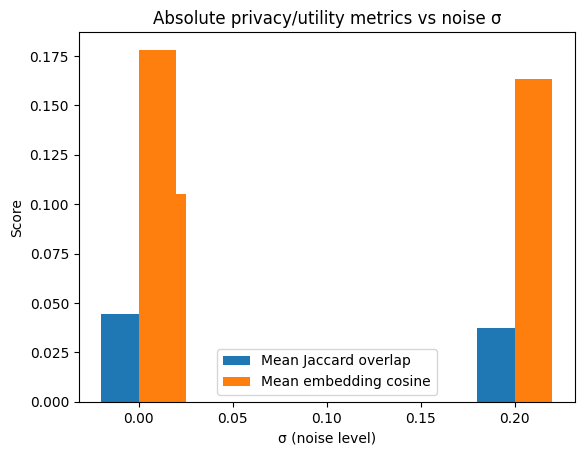

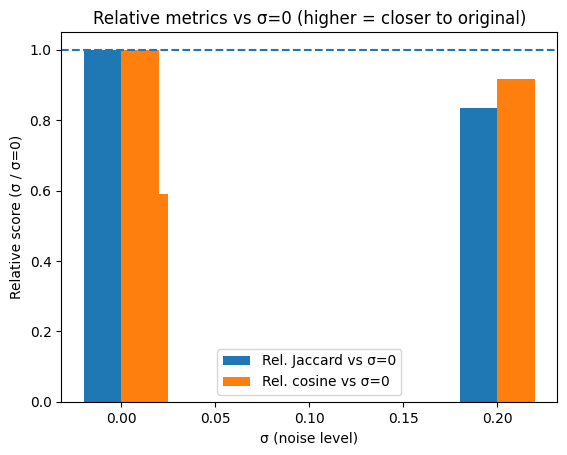

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# 1. Point these to your CSVs (0 plus two noisy sigmas)
# =========================
# Make sure these files exist: run the full pipeline once per sigma value.
config_files = {
    "sigma_0.0": "/content/drive/MyDrive/DiffPriv/Yelp/metrics_sigma_0.csv",  # baseline
    "sigma_0.2": "/content/drive/MyDrive/DiffPriv/Yelp/metrics_sigma_0.2.csv",  # noise level 1
    "sigma_0.005": "/content/drive/MyDrive/DiffPriv/Yelp/metrics_sigma_0.005.csv",  # noise level 2
    "sigma_0.5": "/content/drive/MyDrive/DiffPriv/Yelp/metrics_sigma_0.5.csv",  # noise level 3
}
# ^ Change 0.2 / 0.5 to whatever two sigmas you actually care about.

rows = []

for cfg_name, csv_path in config_files.items():
    df = pd.read_csv(csv_path)

    required = {"jaccard_overlap", "embedding_cosine_similarity"}
    if not required.issubset(df.columns):
        raise ValueError(f"{csv_path} is missing required columns {required}")

    rows.append(
        {
            "config": cfg_name,
            "mean_jaccard": df["jaccard_overlap"].mean(),
            "mean_cosine": df["embedding_cosine_similarity"].mean(),
        }
    )

# =========================
# 2. Build summary table with relative metrics vs sigma=0
# =========================
summary = pd.DataFrame(rows)

# Extract numeric sigma for sorting / plotting
summary["sigma"] = (
    summary["config"]
    .str.extract(r"sigma_([0-9.]+)")
    .astype(float)
)

summary = summary.sort_values("sigma").set_index("config")

# Use sigma=0 as reference (assumes it's the first row after sort)
ref = summary.iloc[0]

# Relative metrics vs reference (this is what you’ll show as “Effect of noise”)
summary["rel_jaccard"] = summary["mean_jaccard"] / ref["mean_jaccard"]
summary["rel_cosine"]  = summary["mean_cosine"]  / ref["mean_cosine"]

# Nicely rounded for reporting / table in paper
summary = summary.round(
    {
        "mean_jaccard": 6,
        "mean_cosine": 6,
        "rel_jaccard": 3,
        "rel_cosine": 3,
    }
)

print("==== Privacy/Utility Summary Across Noise Levels ====")
print(summary)

# =========================
# 3. Plot metrics vs sigma
# =========================
# Basic bar plots; let matplotlib choose colors
sigmas = summary["sigma"].values
mean_jaccard = summary["mean_jaccard"].values
mean_cosine  = summary["mean_cosine"].values
rel_jaccard  = summary["rel_jaccard"].values
rel_cosine   = summary["rel_cosine"].values

# (a) Absolute means
plt.figure()
plt.bar(sigmas - 0.01, mean_jaccard, width=0.02, label="Mean Jaccard overlap")
plt.bar(sigmas + 0.01, mean_cosine,  width=0.02, label="Mean embedding cosine")
plt.xlabel("σ (noise level)")
plt.ylabel("Score")
plt.title("Absolute privacy/utility metrics vs noise σ")
plt.legend()
plt.show()

# (b) Relative to σ=0
plt.figure()
plt.bar(sigmas - 0.01, rel_jaccard, width=0.02, label="Rel. Jaccard vs σ=0")
plt.bar(sigmas + 0.01, rel_cosine,  width=0.02, label="Rel. cosine vs σ=0")
plt.axhline(1.0, linestyle="--")  # reference line for baseline
plt.xlabel("σ (noise level)")
plt.ylabel("Relative score (σ / σ=0)")
plt.title("Relative metrics vs σ=0 (higher = closer to original)")
plt.legend()
plt.show()


Loading /content/drive/MyDrive/DiffPriv/Yelp/metrics_sigma_0.csv
Loading /content/drive/MyDrive/DiffPriv/Yelp/metrics_sigma_0.2.csv
Loading /content/drive/MyDrive/DiffPriv/Yelp/metrics_sigma_0.005.csv
Loading /content/drive/MyDrive/DiffPriv/Yelp/metrics_sigma_0.5.csv
Loaded sigmas: [np.float64(0.0), np.float64(0.005), np.float64(0.2), np.float64(0.5)]


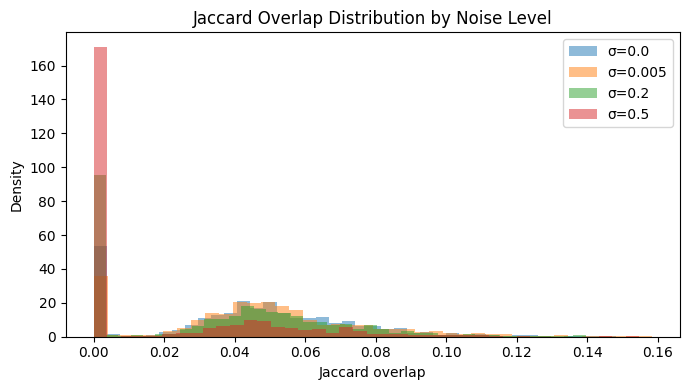

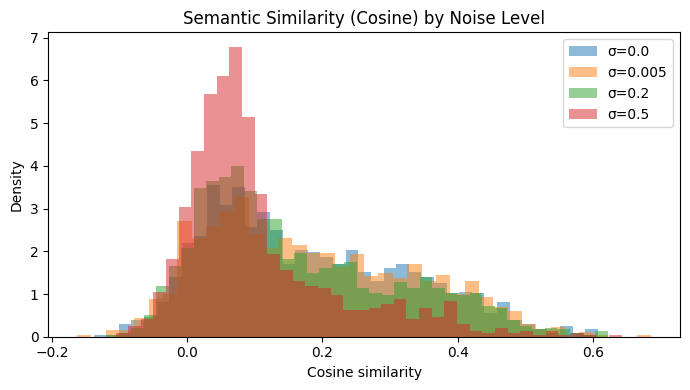

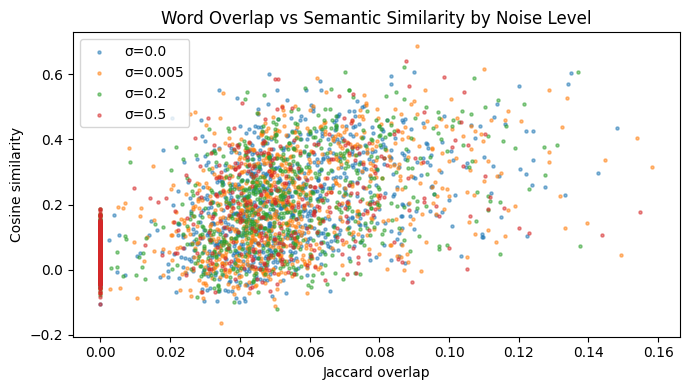

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# 1) Load all sigma CSVs and stack
# =========================
config_files = {
    "sigma_0.0": "/content/drive/MyDrive/DiffPriv/Yelp/metrics_sigma_0.csv",  # baseline
    "sigma_0.2": "/content/drive/MyDrive/DiffPriv/Yelp/metrics_sigma_0.2.csv",  # noise level 1
    "sigma_0.005": "/content/drive/MyDrive/DiffPriv/Yelp/metrics_sigma_0.005.csv",  # noise level 2
    "sigma_0.5": "/content/drive/MyDrive/DiffPriv/Yelp/metrics_sigma_0.5.csv",  # noise level 2
}

dfs = []

for cfg_name, csv_path in config_files.items():
    print(f"Loading {csv_path}")
    df = pd.read_csv(csv_path)

    # keep only what we need
    df = df[["jaccard_overlap", "embedding_cosine_similarity"]].copy()

    # parse numeric sigma from the name (e.g., "sigma_0.2" -> 0.2)
    sigma_val = float(cfg_name.split("_")[-1])
    df["sigma"] = sigma_val

    dfs.append(df)

all_df = pd.concat(dfs, ignore_index=True)
sigmas = sorted(all_df["sigma"].unique())
print("Loaded sigmas:", sigmas)

# =========================
# 2) Comparative histograms
# =========================

# --- Jaccard overlap histograms per sigma (overlaid) ---
plt.figure(figsize=(7, 4))
bins = 40

for s in sigmas:
    sub = all_df[all_df["sigma"] == s]
    plt.hist(
        sub["jaccard_overlap"],
        bins=bins,
        alpha=0.5,
        density=True,
        label=f"σ={s}",
    )

plt.title("Jaccard Overlap Distribution by Noise Level")
plt.xlabel("Jaccard overlap")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# --- Cosine similarity histograms per sigma (overlaid) ---
plt.figure(figsize=(7, 4))

for s in sigmas:
    sub = all_df[all_df["sigma"] == s]
    plt.hist(
        sub["embedding_cosine_similarity"],
        bins=bins,
        alpha=0.5,
        density=True,
        label=f"σ={s}",
    )

plt.title("Semantic Similarity (Cosine) by Noise Level")
plt.xlabel("Cosine similarity")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# =========================
# 3) Scatter: Jaccard vs Cosine, colored by sigma
# =========================

# downsample a bit if it's too dense (optional)
scatter_df = all_df.copy()
if len(scatter_df) > 4000:
    scatter_df = scatter_df.sample(4000, random_state=42)

plt.figure(figsize=(7, 4))
for s in sigmas:
    sub = scatter_df[scatter_df["sigma"] == s]
    plt.scatter(
        sub["jaccard_overlap"],
        sub["embedding_cosine_similarity"],
        s=5,
        alpha=0.5,
        label=f"σ={s}",
    )

plt.title("Word Overlap vs Semantic Similarity by Noise Level")
plt.xlabel("Jaccard overlap")
plt.ylabel("Cosine similarity")
plt.legend()
plt.tight_layout()
plt.show()


In [1]:
import os, re
from glob import glob
import pandas as pd
from IPython.display import display

# === EDIT THIS ===
OUT_DIR = "/content/drive/MyDrive/DiffPriv/Yelp"

pd.set_option("display.max_colwidth", 120)
pd.set_option("display.max_columns", 200)

def _sigma_from_path(fp: str):
    m = re.search(r"metrics_sigma_([0-9.]+)\.csv$", os.path.basename(fp))
    return float(m.group(1)) if m else None

print("OUT_DIR:", OUT_DIR)

# -------------------------
# 1) List CSVs
# -------------------------
metric_files = sorted(glob(f"{OUT_DIR}/metrics_sigma_*.csv"), key=_sigma_from_path)
feat_files   = sorted(glob(f"{OUT_DIR}/feature_report_sigma_*.csv"))
summary_file = f"{OUT_DIR}/summary_across_sigmas.csv"

print("\nFound metrics:", len(metric_files))
for fp in metric_files: print(" -", os.path.basename(fp))

print("\nFound feature reports:", len(feat_files))
for fp in feat_files: print(" -", os.path.basename(fp))

print("\nSummary exists:", os.path.exists(summary_file), "|", os.path.basename(summary_file))

# -------------------------
# 2) Show + stats for metrics files
# -------------------------
metrics_summary_rows = []

for fp in metric_files:
    sigma = _sigma_from_path(fp)
    df = pd.read_csv(fp)

    print("\n" + "="*90)
    print(f"METRICS σ={sigma}  |  rows={len(df)}  cols={len(df.columns)}  file={os.path.basename(fp)}")
    print("="*90)

    display(df.head(5))

    # basic stats
    cols = [c for c in ["jaccard_overlap", "embedding_cosine_similarity"] if c in df.columns]
    if cols:
        print("\n.describe() on key metrics:")
        display(df[cols].describe().T)

        metrics_summary_rows.append({
            "sigma": sigma,
            "n": len(df),
            "mean_jaccard": df["jaccard_overlap"].mean() if "jaccard_overlap" in df else None,
            "std_jaccard": df["jaccard_overlap"].std() if "jaccard_overlap" in df else None,
            "p50_jaccard": df["jaccard_overlap"].median() if "jaccard_overlap" in df else None,
            "mean_cosine": df["embedding_cosine_similarity"].mean() if "embedding_cosine_similarity" in df else None,
            "std_cosine": df["embedding_cosine_similarity"].std() if "embedding_cosine_similarity" in df else None,
            "p50_cosine": df["embedding_cosine_similarity"].median() if "embedding_cosine_similarity" in df else None,
        })

# consolidated metrics summary
if metrics_summary_rows:
    metrics_summary = pd.DataFrame(metrics_summary_rows).sort_values("sigma").reset_index(drop=True)
    print("\n" + "#"*90)
    print("CONSOLIDATED METRICS SUMMARY (by sigma)")
    print("#"*90)
    display(metrics_summary)

# -------------------------
# 3) Show + leakage stats for feature_report files
# -------------------------
leak_summary_rows = []

def safe_mean_bool(series):
    # handles 0/1 or True/False columns
    if series is None:
        return None
    s = series.dropna()
    if s.empty:
        return None
    if s.dtype == bool:
        return float(s.mean())
    # if strings "True"/"False"
    if s.dtype == object:
        s2 = s.astype(str).str.lower().map({"true": 1, "false": 0})
        if s2.notna().any():
            return float(s2.dropna().mean())
    # numeric
    try:
        return float(pd.to_numeric(s, errors="coerce").dropna().mean())
    except Exception:
        return None

for fp in feat_files:
    # parse sigma from filename
    m = re.search(r"feature_report_sigma_([0-9.]+)\.csv$", os.path.basename(fp))
    sigma = float(m.group(1)) if m else None

    df = pd.read_csv(fp)

    print("\n" + "="*90)
    print(f"FEATURE REPORT σ={sigma}  |  rows={len(df)}  cols={len(df.columns)}  file={os.path.basename(fp)}")
    print("="*90)
    display(df.head(5))

    leak_cols = [
        "leaked_email_any",
        "leaked_phone_any",
        "leaked_name_any",
        "leaked_address_any",
    ]
    present = [c for c in leak_cols if c in df.columns]

    # leakage rates
    row = {"sigma": sigma, "n": len(df)}
    for c in present:
        row[c + "_rate"] = safe_mean_bool(df[c])

    # also include similarity metrics if present (nice to correlate)
    if "jaccard_overlap" in df.columns:
        row["mean_jaccard"] = df["jaccard_overlap"].mean()
    if "embedding_cosine_similarity" in df.columns:
        row["mean_cosine"] = df["embedding_cosine_similarity"].mean()

    leak_summary_rows.append(row)

# consolidated leakage summary
if leak_summary_rows:
    leak_summary = pd.DataFrame(leak_summary_rows).sort_values("sigma").reset_index(drop=True)
    print("\n" + "#"*90)
    print("CONSOLIDATED LEAKAGE SUMMARY (by sigma) — rates are fraction of rows with leakage=True")
    print("#"*90)
    display(leak_summary)

# -------------------------
# 4) Show summary_across_sigmas.csv if it exists
# -------------------------
if os.path.exists(summary_file):
    print("\n" + "#"*90)
    print("summary_across_sigmas.csv")
    print("#"*90)
    df_sum = pd.read_csv(summary_file)
    display(df_sum)
else:
    print("\nNo summary_across_sigmas.csv found (you can regenerate it from metrics files if you want).")


OUT_DIR: /content/drive/MyDrive/DiffPriv/Yelp

Found metrics: 4
 - metrics_sigma_0.csv
 - metrics_sigma_0.005.csv
 - metrics_sigma_0.2.csv
 - metrics_sigma_0.5.csv

Found feature reports: 0

Summary exists: False | summary_across_sigmas.csv

METRICS σ=0.0  |  rows=1268  cols=4  file=metrics_sigma_0.csv


,original,synthetic,jaccard_overlap,embedding_cosine_similarity
0,This woman is an absolute lunatic. Stay away. There are so many better options in Nashville. The owner here is a rig...,"been a long time since I've been here. Not only does it have the most amazing beer selection, but it has the best s...",0.112150,0.237031
1,"If you are unfortunate enough to have to deal with Ditech for your mortgage, you are in for a real treat. I have st...",NaN,0.000000,0.048556
2,WORST COMPANY EVER!\n\nI had the unfortunate experience of having my mortgage sold to Ditech. What a bunch of unedu...,NaN,0.000000,0.019140
3,Avoid at ALL costs. Do NOT do business with Ditech. Do not seek loan originations. Do not expect good customer ser...,my first time visiting the area and I had a great time. I loved their fried oysters. They have a large variety of f...,0.088435,0.053495
4,"Okay, so it's tax time, April 1, and I need my 1098 so my business partner and I can get the info on our rental prop...",and I recently purchased a house in the Santa Barbara County area and I had the pleasure of visiting the Santa Barba...,0.060976,0.055789



.describe() on key metrics:


,count,mean,std,min,25%,50%,75%,max
jaccard_overlap,1268.0,0.044385,0.029740,0.000000,0.028487,0.045759,0.062844,0.148148
embedding_cosine_similarity,1268.0,0.178119,0.147527,-0.138438,0.058632,0.147248,0.289959,0.607398



METRICS σ=0.005  |  rows=1268  cols=4  file=metrics_sigma_0.005.csv


,original,synthetic,jaccard_overlap,embedding_cosine_similarity
0,This woman is an absolute lunatic. Stay away. There are so many better options in Nashville. The owner here is a rig...,"'s best burger joint in the area is located at 905 Westheimer. The food is amazing, the staff is always friendly, a...",0.065421,0.163738
1,"If you are unfortunate enough to have to deal with Ditech for your mortgage, you are in for a real treat. I have st...","this place. They have amazing ice cream. They have a nice selection of whipped cream, eggs, and butter. I love t...",0.106195,0.002559
2,WORST COMPANY EVER!\n\nI had the unfortunate experience of having my mortgage sold to Ditech. What a bunch of unedu...,"a great restaurant? I started out by being pleasantly surprised at the food. The waitress was very attentive, very ...",0.072464,0.147806
3,Avoid at ALL costs. Do NOT do business with Ditech. Do not seek loan originations. Do not expect good customer ser...,to take a break and try out something new for this Saturday brunch and the selection was pretty good. I ordered a sa...,0.071895,0.056551
4,"Okay, so it's tax time, April 1, and I need my 1098 so my business partner and I can get the info on our rental prop...","time I went to the restaurant for dinner on a Saturday night, I was the only person who had a drink and no food. I ...",0.086420,0.074782



.describe() on key metrics:


,count,mean,std,min,25%,50%,75%,max
jaccard_overlap,1268.0,0.047558,0.029000,0.000000,0.033071,0.047375,0.062662,0.158333
embedding_cosine_similarity,1268.0,0.182137,0.150763,-0.163142,0.060073,0.156877,0.296117,0.686443



METRICS σ=0.2  |  rows=1268  cols=4  file=metrics_sigma_0.2.csv


,original,synthetic,jaccard_overlap,embedding_cosine_similarity
0,This woman is an absolute lunatic. Stay away. There are so many better options in Nashville. The owner here is a rig...,"and I are so happy with the outcome of our vacation. It was a great night out, and it was a beautiful place to stay...",0.075472,0.075230
1,"If you are unfortunate enough to have to deal with Ditech for your mortgage, you are in for a real treat. I have st...","A new, less-than-stellar beer garden in the City of East Side is popping up in New Orleans.\n\nThe concept behind th...",0.060345,-0.052677
2,WORST COMPANY EVER!\n\nI had the unfortunate experience of having my mortgage sold to Ditech. What a bunch of unedu...,NaN,0.000000,0.019140
3,Avoid at ALL costs. Do NOT do business with Ditech. Do not seek loan originations. Do not expect good customer ser...,going on here?\n\nWe recently sat in our hotel room and were greeted by our room manager. The receptionist was very ...,0.053691,0.106227
4,"Okay, so it's tax time, April 1, and I need my 1098 so my business partner and I can get the info on our rental prop...",NaN,0.000000,0.037834



.describe() on key metrics:


,count,mean,std,min,25%,50%,75%,max
jaccard_overlap,1268.0,0.037070,0.031795,0.000000,0.000000,0.041619,0.057216,0.139535
embedding_cosine_similarity,1268.0,0.163133,0.146357,-0.119999,0.049988,0.122432,0.258820,0.621809



METRICS σ=0.5  |  rows=1268  cols=4  file=metrics_sigma_0.5.csv


,original,synthetic,jaccard_overlap,embedding_cosine_similarity
0,This woman is an absolute lunatic. Stay away. There are so many better options in Nashville. The owner here is a rig...,"of the store, Mr. Thomas, said he could not comment on the issue because it was pending, and the store had been clos...",0.061404,0.176228
1,"If you are unfortunate enough to have to deal with Ditech for your mortgage, you are in for a real treat. I have st...",woman in a wheelchair is about to get a new wheelchair. She was unable to walk with her legs raised as she was havin...,0.085470,0.032796
2,WORST COMPANY EVER!\n\nI had the unfortunate experience of having my mortgage sold to Ditech. What a bunch of unedu...,"boyfriend and I were staying on the same block, and I was very excited to find this place. We were going for a date...",0.105263,0.003439
3,Avoid at ALL costs. Do NOT do business with Ditech. Do not seek loan originations. Do not expect good customer ser...,"name of this place was ""The New American."" Today, it is the largest chain of restaurants in the world. \n\nThe resta...",0.053691,-0.005400
4,"Okay, so it's tax time, April 1, and I need my 1098 so my business partner and I can get the info on our rental prop...","lot of the things I have experienced at the Davenport store are pretty typical of the places I've been, but there is...",0.064327,-0.030308



.describe() on key metrics:


,count,mean,std,min,25%,50%,75%,max
jaccard_overlap,1268.0,0.018669,0.029060,0.000000,0.000000,0.000000,0.040536,0.154762
embedding_cosine_similarity,1268.0,0.105200,0.115118,-0.105935,0.032957,0.072063,0.137871,0.642423



##########################################################################################
CONSOLIDATED METRICS SUMMARY (by sigma)
##########################################################################################


,sigma,n,mean_jaccard,std_jaccard,p50_jaccard,mean_cosine,std_cosine,p50_cosine
0,0.000,1268,0.044385,0.029740,0.045759,0.178119,0.147527,0.147248
1,0.005,1268,0.047558,0.029000,0.047375,0.182137,0.150763,0.156877
2,0.200,1268,0.037070,0.031795,0.041619,0.163133,0.146357,0.122432
3,0.500,1268,0.018669,0.029060,0.000000,0.105200,0.115118,0.072063



No summary_across_sigmas.csv found (you can regenerate it from metrics files if you want).
